# Sentiment Analysis of Nigerian Presidential Election Tweets

**Anna Adobamen**  
LING48 Final Project - Spring 2023

In this project, I aim to perform sentiment analysis on tweets related to the Nigerian Presidential Election. The goal is to classify these tweets using Support Vector Machines (SVM) and BERT models.

## Introduction
Social media platforms like Twitter have become significant sources of public opinion and sentiment during elections. Analyzing the sentiment expressed in tweets can provide insights into public perceptions and attitudes towards political candidates and events.

## Methodology
To perform sentiment analysis, I will utilize two approaches: SVM and BERT.

1. **Support Vector Machines (SVM):** SVM is a popular machine learning algorithm used for classification tasks. The SVM classifier is trained on the training embeddings and corresponding labels using the fit method and then used to predict labels of more tweets.

2. **BERT (Bidirectional Encoder Representations from Transformers):** BERT is a state-of-the-art natural language processing model that excels in understanding context and semantics. IThe BERT model is loaded from the 'bert-base-uncased' pretrained model. The training and testing inputs are converted into PyTorch tensors. The BERT embeddings are extracted from the [CLS] token for both the training and testing inputs using the BERT model.

## Dataset
The dataset used for this project consists of tweets related to the Nigerian Presidential Election. It contains various features such as the tweet text, user information, and timestamps. The dataset will be preprocessed to remove irrelevant columns and clean the text data. I also used a traning set with tweets labeled according to 5 emotions.

## Project Workflow
1. Load and preprocess the dataset
2. Perform exploratory data analysis to gain insights into the dataset
3. BERT Embeddings extraction
4. SVM classification
5. Evaluate the performance of both models using appropriate metrics
6. Generate visualizations to illustrate the findings


In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel




In [2]:
# Step 1: Preprocess the data
# Assuming you have your text data in a DataFrame called 'df'
df= pd.read_csv('training.csv', delimiter=',', header=None)
df = df.drop([0])
df = df.iloc[:10000,:]

label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# Convert labels to integer type if needed
df[1] = df[1].astype(int)

# Replace numerical labels with emotions
df[1] = df[1].map(label_mapping)
labels = df[1]
df[1].value_counts()
df.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       10000 non-null  object
 1   1       10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB


In [3]:
# Tokenize the text data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized = df[1].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Pad the tokenized sequences to a fixed length
max_len = max(map(len, tokenized))
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])




In [4]:
# Split the data into train and test sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(padded, labels, test_size=0.2, random_state=42)


In [5]:
# Step 2: Extract BERT embeddings
model = BertModel.from_pretrained('bert-base-uncased')

# Convert the numpy arrays to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)

# Extract the BERT embeddings for train and test inputs
with torch.no_grad():
    train_embeddings = model(train_inputs)[0][:, 0, :].numpy()  # Extract embeddings from the [CLS] token
    test_embeddings = model(test_inputs)[0][:, 0, :].numpy()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Step 3: Train the SVM classifier
svm = SVC()
svm.fit(train_embeddings, train_labels)

# Step 4: Evaluate the SVM classifier
predictions = svm.predict(test_embeddings)
print(classification_report(test_labels, predictions))


              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       279
        fear       1.00      1.00      1.00       210
         joy       1.00      1.00      1.00       710
        love       1.00      1.00      1.00       170
     sadness       1.00      1.00      1.00       545
    surprise       1.00      1.00      1.00        86

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [7]:
# Create a DataFrame with predictions and test labels
results = pd.DataFrame({'Test Labels': test_labels, 'Predictions': predictions})

# Print the DataFrame
print(results)


     Test Labels Predictions
6253     sadness     sadness
4685       anger       anger
1732       anger       anger
4743         joy         joy
4522         joy         joy
...          ...         ...
6413         joy         joy
8286         joy         joy
7854        love        love
1096         joy         joy
6930       anger       anger

[2000 rows x 2 columns]


In [90]:
import re
# Dataset of tweets
df2= pd.read_csv('nigerian_presidential_election_2023_tweets.csv', delimiter=',', header=None)

# This is a really large dataset so i will be trying to cut it relevantly

# First I choose a convenient date window(start of february till a week after the elections)
df2[9] = pd.to_datetime(df2[9], errors='coerce')

print(df2[9][1:10])
cutoff_date = '2023-03-04'
cutoff_date2 = '2023-02-01'
df2 = df2[df2[9] < cutoff_date]
df2 = df2[df2[9] > cutoff_date2]


# Next I remove tweets that don't have certain key words pertaining to the 3 candidtes I am focusing on
# Define the list of phrases to keep (full names of candidates as well as what they are colloquially called)
phrases_to_keep = ['peter obi', 'atiku abubakar','bola ahmed tinubu']

# Create a regular expression pattern that matches any of the phrases
pattern = re.compile('|'.join(phrases_to_keep), re.IGNORECASE)

# Filter the DataFrame based on the text column containing the phrases
df2 = df2[df2[10].str.contains(pattern, na=False)]


# Print the updated shape of the DataFrame
print(df2.shape)
indices_to_drop = df2.index[1::2]


1   2023-01-23 20:24:20+00:00
2   2023-01-23 22:20:47+00:00
3   2023-01-23 22:54:22+00:00
4   2023-01-23 18:05:02+00:00
5   2023-01-23 20:25:14+00:00
6   2023-01-24 01:10:30+00:00
7   2023-01-23 22:55:02+00:00
8   2023-01-23 21:53:38+00:00
9   2023-01-23 21:46:50+00:00
Name: 9, dtype: datetime64[ns, UTC]
(3888, 16)


In [91]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


tokenized_df2 = df2[10].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Pad the tokenized sequences to a fixed length
max_len2 = max(map(len, tokenized_df2))
padded2 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_df2])
type(padded2)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-91-e0718e02a3e3>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuple

numpy.ndarray

In [92]:
type(padded2)
print(padded2)
torch.is_tensor(padded2)


[list([101, 2064, 2057, 2428, 3404, 2848, 27885, 2072, 1029, 2064, 2057, 7400, 1996, 3821, 1997, 2023, 2406, 1999, 2010, 2398, 1029, 2079, 2025, 2292, 2115, 6699, 1038, 1529, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 19330, 2546, 18418, 20348, 2509, 4492, 102])
 list([101, 1017, 1012, 1996, 11906, 1997, 1996, 2877, 4883, 4018, 2720, 1012, 2848, 27885, 2072, 1997, 1996, 4428, 2283, 7387, 2110, 22867, 1012, 8040, 1529, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 19296, 6199, 4523, 5602, 2549, 2546, 102])
 list([101, 1016, 1012, 1996, 11906, 1997, 1996, 2877, 4883, 4018, 2720, 1012, 2848, 27885, 2072, 1997, 1996, 4428, 2283, 7387, 2110, 22867, 1012, 8040, 1529, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 27937, 2487, 15992, 7011, 2595, 2860, 2361, 102])
 ...
 list([101, 2145, 2667, 2000, 2693, 2006, 2044, 2035, 2023, 2602, 22894, 7911, 2021, 1045, 2145, 2903, 1999, 2026, 2343, 1006, 2848, 27885, 2072, 1007, 1012, 1001, 27885, 2072, 19291, 1001, 27885, 8524, 6916, 1001, 27

False

In [93]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Convert the list of lists to a list of tensors
tensor_list = [torch.tensor(seq) for seq in padded2]

# Pad the sequences to the maximum length
padded2_tensor = pad_sequence(tensor_list, batch_first=True)

# Clone and detach the tensor to create a new tensor without the computational graph
padded2_tensor = padded2_tensor.clone().detach().to(torch.long)


In [94]:

from tqdm import tqdm

embeddings = []
batch_size = 100

with torch.no_grad():
    for i in tqdm(range(0, len(padded2_tensor), batch_size)):
        batch = padded2_tensor[i:i + batch_size]
        batch_embeddings = model(batch)[0][:, 0, :].numpy()
        embeddings.append(batch_embeddings)

embeddings = np.concatenate(embeddings, axis=0)




100%|██████████| 39/39 [12:36<00:00, 19.41s/it]


In [95]:
predictions = svm.predict(embeddings)

In [96]:
df2['Predictions'] = predictions
pd.set_option('display.max_rows', None)  
# Print the updated df2 with predictions
print(df2[[10, 'Predictions']])



                                                      10 Predictions
46     Can we really trust Peter Obi? \nCan we thrust...       anger
50     3. The Chronicles of the leading Presidential ...       anger
65     2. The Chronicles of the leading Presidential ...       anger
66     1. The Chronicles of the leading Presidential ...       anger
76     Dear Nigerians, even your fellow West Africans...       anger
110    The "Can Do" and "Can Become" Spirit of Nigeri...       anger
163    Okay now wtf did I just watch??? \n\nThis coun...       anger
217    @vanguardngrnews Mr. Peter Obi has the endorse...        fear
235    Ahead of the forthcoming general election, LP’...        fear
242    Another massive outing today by Asiwaju Bola A...       anger
253    If Peter Obi doesn’t win the upcoming general ...       anger
270    Thé love osun people have for Asiwaju Bola Ahm...        fear
306    "Let's support a leader with a proven track re...       anger
334    LP's presidential and VP, P

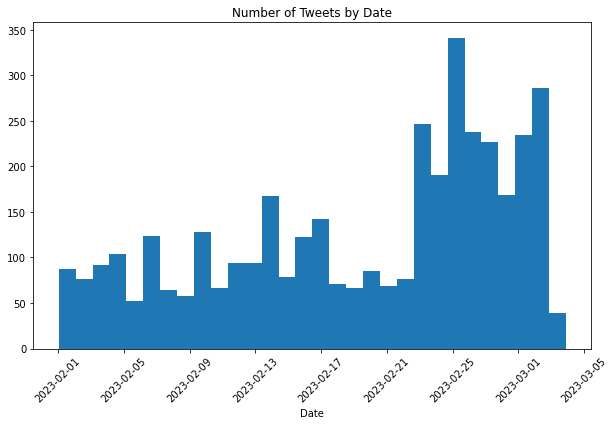

In [97]:
import matplotlib.pyplot as plt

# Create a larger figure with a specified size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the histogram
plt.hist(df2[9], bins=30)

# Set the x-axis label and title
plt.xlabel('Date')
plt.title('Number of Tweets by Date')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()


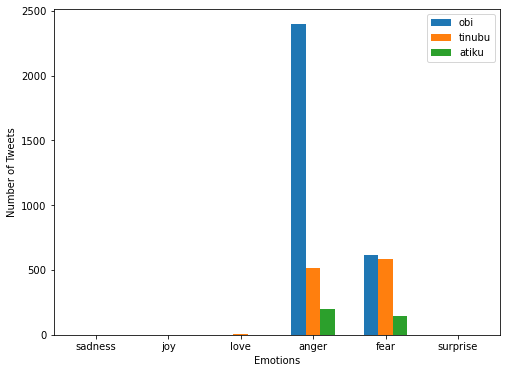

In [98]:
import matplotlib.pyplot as plt

# Define the emotions and candidates
emotions = ['sadness','joy','love','anger','fear','surprise']
candidates = [ 'obi', 'tinubu', 'atiku']

# Create a dictionary to store the counts for each emotion-candidate combination
counts = {}

# Create a dictionary to store the counts for each emotion-candidate combination
counts = {}

# Initialize the counts to zero
for emotion in emotions:
    for candidate in candidates:
        key = f"{emotion}_{candidate}"
        counts[key] = 0

# Count the tweets for each emotion-candidate combination
for index, row in df2.iterrows():
    text = row[10].lower()
    emotion = row['Predictions']
    for candidate in candidates:
        if candidate in text:
            key = f"{emotion}_{candidate}"
            counts[key] += 1

# Plot the counts
fig, ax = plt.subplots(figsize=(8, 6))

x = range(len(emotions))
width = 0.2

for i, candidate in enumerate(candidates):
    values = [counts[f"{emotion}_{candidate}"] for emotion in emotions]
    ax.bar([val + i * width for val in x], values, width, label=candidate)

ax.set_xlabel('Emotions')
ax.set_ylabel('Number of Tweets')
ax.set_xticks([val + width for val in x])
ax.set_xticklabels(emotions)
ax.legend()

plt.show()


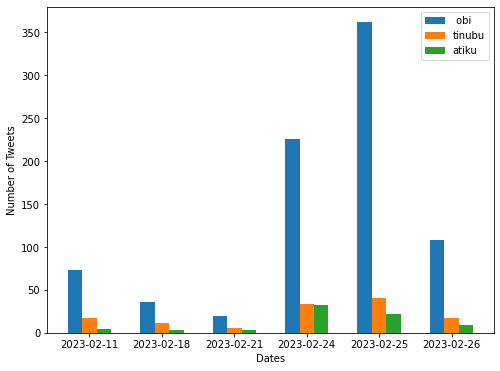

In [109]:
import matplotlib.pyplot as plt

# Define the candidates and dates
candidates = [' obi', 'tinubu', 'atiku']
dates = ['2023-02-11', '2023-02-18', '2023-02-21', '2023-02-24','2023-02-25','2023-02-26']

# Create a dictionary to store the counts for each candidate-date combination
counts = {}

# Initialize the counts to zero
for candidate in candidates:
    for date in dates:
        key = f"{candidate}_{date}"
        counts[key] = 0

# Count the tweets for each candidate-date combination
for index, row in df2.iterrows():
    text = row[10].lower()
    prediction = row['Predictions']
    date = str(row[9].date())  # Extract the date part from the datetime
    for candidate in candidates:
        if candidate in text and date in dates:
            key = f"{candidate}_{date}"
            counts[key] += 1

# Plot the counts
fig, ax = plt.subplots(figsize=(8, 6))

x = range(len(dates))
width = 0.2

for i, candidate in enumerate(candidates):
    values = [counts[f"{candidate}_{date}"] for date in dates]
    ax.bar([val + i * width for val in x], values, width, label=candidate)

ax.set_xlabel('Dates')
ax.set_ylabel('Number of Tweets')
ax.set_xticks([val + width for val in x])
ax.set_xticklabels(dates)
ax.legend()

plt.show()


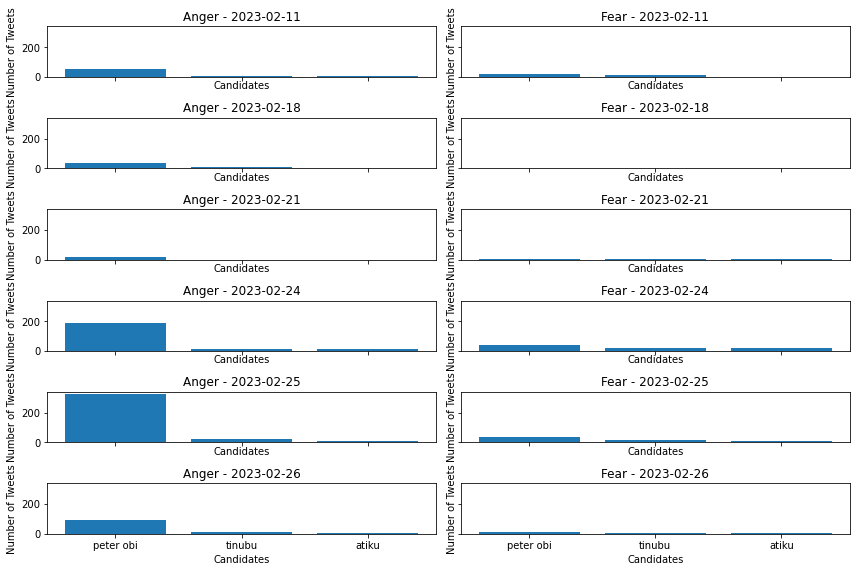

In [110]:
import matplotlib.pyplot as plt

# Define the candidates, emotions, and dates
candidates = ['peter obi', 'tinubu', 'atiku']
emotions = ['anger', 'fear']
dates = ['2023-02-11', '2023-02-18', '2023-02-21', '2023-02-24', '2023-02-25', '2023-02-26']

# Create a dictionary to store the counts for each candidate-emotion-date combination
counts = {}

# Initialize the counts to zero
for candidate in candidates:
    for emotion in emotions:
        for date in dates:
            key = f"{candidate}_{emotion}_{date}"
            counts[key] = 0

# Count the tweets for each candidate-emotion-date combination
for index, row in df2.iterrows():
    text = row[10].lower()
    prediction = row['Predictions']
    date = str(row[9].date())  # Extract the date part from the datetime
    for candidate in candidates:
        if candidate in text and date in dates:
            for emotion in emotions:
                if emotion in prediction:
                    key = f"{candidate}_{emotion}_{date}"
                    counts[key] += 1

# Plot the counts for each emotion at each date
fig, axs = plt.subplots(len(dates), len(emotions), figsize=(12, 8), sharex=True, sharey=True)

for i, date in enumerate(dates):
    for j, emotion in enumerate(emotions):
        ax = axs[i, j]
        x = range(len(candidates))
        values = [counts[f"{candidate}_{emotion}_{date}"] for candidate in candidates]
        ax.bar(x, values)
        ax.set_xticks(x)
        ax.set_xticklabels(candidates)
        ax.set_xlabel('Candidates')
        ax.set_ylabel('Number of Tweets')
        ax.set_title(f"{emotion.capitalize()} - {date}")
        

plt.tight_layout()
plt.show()
